<span style="font-size:24px; font-weight:bold;">Sparse GP explaination</span>

Author: Zidong Chen

There are many different types of sparse Gaussian Processes (GP), but here we will focus on the variational sparse Gaussian process (VSGP).

**Introduction:** VSGP uses variational inference to directly approximate the posterior GP mean and covariance function. Like other SGP methods, VSGP also uses inducing points that reduce the computational complexity from $\mathbf{O}(n^3)$ to $\mathbf{O}(nm^2)$, where $n$ is the size of the training set and $m$ is the size of the inducing points. Suppose we have $m$ inducing points $X_m$, and we want to approximate the true posterior distribution $p(f,f_m \mid y)$ by introducing a variational distribution $q(f,f_m)$ and minimize the [KL divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence).

$$
\text{KL}(q(f,f_m) \parallel p(f,f_m \mid y)) = \int \int q(f,f_m) \log \frac{q(f,f_m)}{p(f,f_m \mid y)} \, df \, df_m
$$

Where $f$ is the latent function values, and $f_m$ is the function values of inducing points.

Minimizing the KL divergence is equivalent to maximizing the evidence lower bound (ELBO) because:

$$
\log p(X) = \text{ELBO} + \text{KL}(q(\theta) \parallel p(\theta \mid X))
$$

where $\log p(X)$ is a constant. More details can be found [here](https://en.wikipedia.org/wiki/Evidence_lower_bound).

The lower bound found by [Titsias, 2009](https://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf) after optimization is:

$$
F_V(X_m) = \log N(y \mid 0, \sigma^2 I + Q_{nn}) - \frac{1}{2 \sigma^2} \text{Tr}(\tilde{K})
$$

Where $Q_{nn} = K_{nm} K_{mm}^{-1} K_{mn}$, and $\tilde{K} = K_{nn} - K_{nm} K_{mm}^{-1} K_{mn}$.

By minimizing this negative lower bound we can find optimal inducing variables (optimal location of inducing input and their values), then we can compute the optimal mean and covariance for $X_m$:

$$
\mu_m = \frac{1}{\sigma_y^2} K_{mm} \Sigma K_{mn} y
$$

$$
A_m = K_{mm} \Sigma K_{mm}
$$

Where 

$$
\Sigma = \left( K_{mm} + \sigma_y^{-2} K_{mn} K_{nm} \right)^{-1}
$$

Finally, we use the optimal $\mu_m$ and $A_m$ for prediction.

Now lets build this model with pytorch

In [6]:
import torch
import torch.nn as nn
import numpy as np
import kernel
from matplotlib import pyplot as plt
import os
# from torch.autograd import Variable

# Variational Sparse Gaussian Processes

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS 

JITTER = 1e-3
torch.manual_seed(1)  
EPS = 1e-10
PI = 3.1415

xtr.size: torch.Size([1000, 1]) ytr.size: torch.Size([1000, 1])
xte.size: torch.Size([1000, 1]) yte.size: torch.Size([1000, 1])


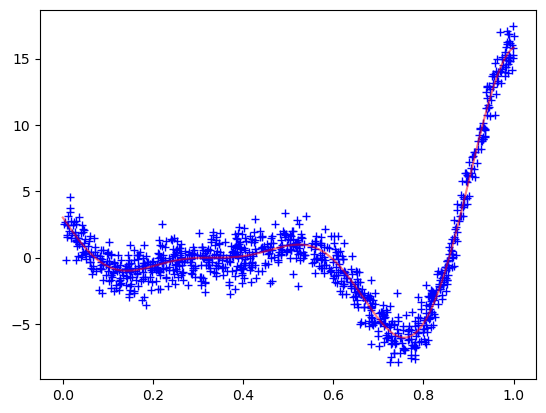

In [7]:
#train_set
xtr = torch.rand(1000, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(1000, 1) * 1

#test_set
xte = torch.linspace(0, 1, 1000).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

In [8]:
# initialize inducing point as model parameter
xm=nn.Parameter(torch.rand(20, 1)) #Inducing point we want to optimize

In [9]:
# define kernel parameters
log_length_scale = nn.Parameter(torch.zeros(xte.size(1)))
log_scale = nn.Parameter(torch.zeros(1))
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value. 

In [10]:
def kernel(X1, X2, log_length_scale, log_scale): # 定义核函数没有加linear

    X1 = X1 / log_length_scale.exp()
    X2 = X2 / log_length_scale.exp()

    X1_norm2 = X1 * X1
    X2_norm2 = X2 * X2

    K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0), X2.size(0))  #this is the effective Euclidean distance matrix between X1 and X2.
    K = log_scale.exp() * torch.exp(-0.5 * K)
    return K



Now we make the lower bound mentioned above easier for programming, more numerically stable during the optimization, and more computationally efficient.

The probability density function is given by:
$$
p(y \mid 0, \sigma^2 I + Q_{nn}) = \frac{1}{(2\pi)^{n/2} |\sigma^2 I + Q_{nn}|^{1/2}} \exp\left(-\frac{1}{2} y^T (\sigma^2 I + Q_{nn})^{-1} y\right)
$$

Taking the logarithm:
$$
\log p(y \mid 0, \sigma^2 I + Q_{nn}) = -\frac{n}{2} \log (2\pi) - \frac{1}{2} \log |\sigma^2 I + K_{nm} K_{mm}^{-1} K_{mn}| - \frac{1}{2} y^T (\sigma^2 I + K_{nm} K_{mm}^{-1} K_{mn})^{-1} y
$$

Let \(K_{mm} = LL^T\) (where \(L\) is a lower triangular matrix obtained by [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)), and let:
$$
\frac{1}{\sigma^2} K_{nm} K_{mm}^{-1} K_{mn} = AA^T
$$

Then, we express the determinant as:
$$
\frac{1}{2} \log |\sigma^2 I + K_{nm} K_{mm}^{-1} K_{mn}| = \frac{1}{2} \log |I + AA^T| + \frac{n}{2}\log\sigma^2, \quad A = L^{-1} K_{mn} \sigma^{-1}
$$

Let $I + AA^T = B$. Applying Cholesky decomposition on $B$, we obtain $B = L_B L_B^T$.

Using the [Woodbury identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) for the inverse calculation:
$$
(\sigma^2 I + K_{nm} K_{mm}^{-1} K_{mn})^{-1} = \sigma^{-2} I - \sigma^{-2} K_{nm} (K_{mm} + \sigma^{-2} K_{mn} K_{nm})^{-1} K_{mn} \sigma^{-2}
$$

Define $c$ as:
$$
c = L_B^{-1} A y \sigma^{-1}
$$

Finally, the lower bound becomes:
$$
L(X_m) = -\frac{n}{2} \log(2\pi) - \frac{1}{2} \log |B| - \frac{n}{2} \log \sigma^2_y - \frac{1}{2 \sigma^2_y} y^T y + \frac{1}{2} c^T c - \frac{1}{2 \sigma^2_y} \text{Tr}(K_{nn}) + \frac{1}{2} \text{Tr}(A A^T)
$$


In [54]:
def nlb(xtr,ytr,log_length_scale,log_scale,log_beta,xm): # negtive lower bound as the loss function we want to minimize later
    
    n=xtr.size(0)
    #xms=softplus(xm)
    K_mm = kernel(xm,xm,log_length_scale, log_scale ) + JITTER * torch.eye(xm.size(0))
    K_mn = kernel(xm, xtr, log_length_scale, log_scale)
    K_nn = kernel(xtr, xtr, log_length_scale, log_scale)
    L = torch.linalg.cholesky(K_mm)
    A, _= torch.triangular_solve(K_mn, L, upper=False)
    A=A*torch.sqrt(log_beta.exp())
    AAT = A @ A.t()
    B = torch.eye(xm.size(0))+AAT
    LB=torch.linalg.cholesky(B)
    
    c,_=torch.triangular_solve(A@ytr,LB,upper=False)
    c=c*torch.sqrt(log_beta.exp())
    nlb=n/2* torch.log(2*torch.tensor(PI))+torch.sum(torch.log(torch.diagonal(LB)))+n / 2 * torch.log(1/log_beta.exp())+\
    log_beta.exp()/2 * torch.sum(ytr * ytr)-0.5 * torch.sum(c.squeeze() * c.squeeze())+\
    log_beta.exp()/2 * torch.sum(torch.diagonal(K_nn))-0.5 * torch.trace(AAT)
    return nlb
nlb(xtr,ytr,log_length_scale,log_scale,log_beta,xm)

tensor([3110.7490], grad_fn=<SubBackward0>)

In [55]:
def train_adam(X, Y, log_length_scale, log_scale, log_beta, xm,niter = 50, lr = 0.001):
    
    optimizer = torch.optim.Adam([log_beta, log_length_scale, log_scale,xm], lr = lr)
    optimizer.zero_grad()
    for i in range(niter):
        optimizer.zero_grad()
        # self.update()
        loss = nlb(X,Y,log_length_scale,log_scale,log_beta,xm)
        loss.backward()
        optimizer.step()
        #print(xm,xms)
        #print('iter', i, ' nnl:', loss.item())
       
        #print the likelihood
        #print('iter', i, 'nnl:{:.5f}'.format(loss.item()),'likelihood:{:.9f}'.format((-loss).exp().item()) )


In [56]:
def OPT(xm,xtr,ytr,log_length_scale, log_scale, log_beta):
    #xms=softplus(xm)
    K_mm = kernel(xm,xm,log_length_scale, log_scale ) + JITTER* torch.eye(xm.size(0))
    K_mm_inv = torch.inverse(K_mm)
    K_mn = kernel(xm, xtr, log_length_scale, log_scale)
    K_nm=K_mn.t()
    sigma=torch.inverse(K_mm+log_beta.exp()*K_mn@K_nm)
    
    mean_m=log_beta.exp() * (K_mm @ sigma @ K_mn)@ytr
    A_m=K_mm@sigma@K_mm
    return mean_m, A_m,K_mm_inv   #we need to use K_mm inverse for prediction
    
#mean_m,A_m,K_mm_inv=OPT(xm,xtr,ytr,log_length_scale, log_scale, log_beta)

CPU times: total: 59.9 s
Wall time: 7.57 s


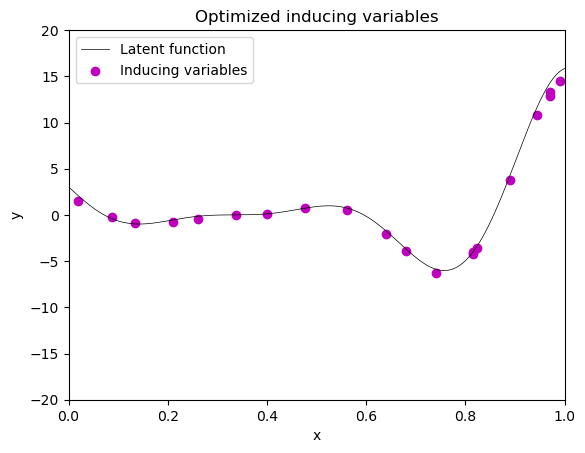

In [57]:
%%time
## train VSGP to find optimal Xm
train_adam(xtr, ytr, log_length_scale, log_scale, log_beta, xm,200, 0.01)
with torch.no_grad():
    mean_m,A_m,K_mm_inv=OPT(xm,xtr,ytr,log_length_scale, log_scale, log_beta)

plt.plot(xte, yte, label='Latent function', c='k', lw=0.5)
plt.scatter(xm.detach().numpy(), mean_m.detach().numpy(), label='Inducing variables', c='m')
plt.title('Optimized inducing variables')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.ylim(-20,20)
plt.legend()

In [58]:
def forward(xte,log_length_scale, log_scale, log_beta,xm,mean_m,A_m,K_mm_inv):
    
    K_tt=kernel(xte,xte,log_length_scale, log_scale)
    K_tm=kernel(xte,xm,log_length_scale, log_scale )
    K_mt= K_tm.t()
    ypred=(K_tm@K_mm_inv)@mean_m
    yvar=K_tt-K_tm@K_mm_inv@K_mt+K_tm@K_mm_inv@A_m@K_mm_inv@K_mt
    yvar = yvar.diag().view(-1,1)
    return ypred,yvar

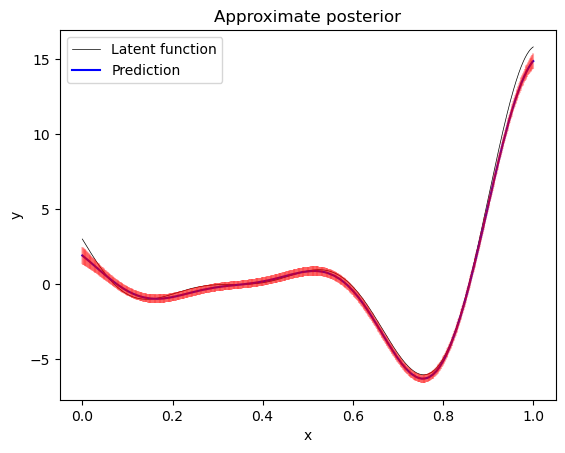

In [59]:
ypred, yvar = forward(xte,log_length_scale, log_scale, log_beta,xm,mean_m,A_m,K_mm_inv)
plt.plot(xte.numpy(), yte.numpy(), label='Latent function', c='k', lw=0.5)
plt.plot(xte.numpy(), ypred.detach(), label='Prediction', c='b')
plt.errorbar(xte.numpy().reshape(1000), ypred.detach().numpy().reshape(1000),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')

plt.legend();